# Ideal locations for Italian restaurant

**"The Battle of Neighborhoods"**<br/>
Coursera Capstone Project<br/>
Applied Data Science Specialization<br/>
Filipe Brandenburger<br/>
June 2nd, 2002.

### Table of Contents

 - [Introduction & Business Problem](#Introduction-&-Business-Problem)
 - [Data](#Data)
 - [Methodology](#Methodology)
 - [Results](#Results)
 - [Discussion](#Discussion)
 - [Conclusion](#Conclusion)


### Introduction & Business Problem

The owners of a chain of Italian restaurants in Portland, OR wants to expand to the Seattle, WA region, so they commissioned a study to understand which potential locations would be best to open a new establishment.

They are mostly interested in the suburban areas, in particular the downtowns and city centers of the cities in the Greater Seattle Area.

They would like to know more about the existing restaurants in those areas, both to gauge areas where there are already many restaurant choices (so they are typically visit by crowd that might be interested to try the new restaurant) and they're also interested in the potential competition from other comparable establishments, particularly other Italian restaurants that would potentially "split" the customers who are seeking Italian food.


### Data

From interviews with a few locals, we narrowed down a handful of areas that would look interesting, that seem to be "go to" locations for people frequenting restaurants.

We will gather data from Foursquare for these locations, in particular we will look at the total number of restaurants in each one of them. Still looking at the categories, we will narrow these down to determine which are actually sit-down restaurants vs. fast food options or coffee/desert shops.

We will take a closer look at the Italian restaurants in each of these areas, getting all the details for these venues from Foursquare, in order to gauge their price tier, rating and other factors that will help us determine how popular and how good these places are. These are potentially very direct competition, so we would like to avoid an area already overserved by Italian restaurants. We will also include Pizza restaurants in this more detailed search, since that's still quite direct competition.

Finally, after summarizing data for all venues of eacho location, we will segment the locations using a k-means clustering algorithm. By aggregating the data from each cluster, we'll be able to describe high-level location profiles that will help our customer narrow down their search, and finally drill down to the ideal location by looking at the more detailed data for the locations in the most relevant cluster.

<br/>


### Methodology

Here we will use the Jupyter Notebook to collect and process the data from Foursquare and use it to make a recommendation on the best location to open an Italian restaurant.<br/><br/>

In [1]:
import glob
import json
import os
import requests
import sys
import time

import numpy as np
import pandas as pd
import matplotlib as mpl

from sklearn.cluster import KMeans
import folium

Define our global constants.

In [2]:
# Foursquare API client.
FS_CLIENT_ID     = "your-client-id"       # Please fill in with Foursquare API client id information
FS_CLIENT_SECRET = "your-client-secret"   # Please fill in with Foursquare API secret information
FS_API_VERSION   = "20180605"

# Foursquare categories of interest.
FS_CATEGORY_FOOD    = "4d4b7105d754a06374d81259"
FS_CATEGORY_ITALIAN = "4bf58dd8d48988d110941735"
FS_CATEGORY_PIZZA   = "4bf58dd8d48988d1ca941735"

# Coordinates and id (names) for candidate locations.
CANDIDATE_LOCATIONS = [
    (47.6759175, -122.2068017, "Downtown Kirkland"),
    (47.6737085, -122.1241935, "Downtown Redmond"),
    (47.7117460, -122.1803455, "Totem Lake Kirkland"),
    (47.7064144, -122.2108842, "Juanita Kirkland"),
    (47.6165065, -122.2034439, "Bellevue Square"),
    (47.6154226, -122.0332381, "Sammamish Downtown"),
    (47.7573512, -122.1540185, "Woodinville"),
    (47.5760386, -122.1724060, "Factoria Mall"),
    (47.4799604, -122.2134103, "Downtown Renton"),
    (47.7198955, -122.2964986, "Downtown Lake City"),
    (47.8285701, -122.2719759, "Alderwood Mall"),
    (47.5440925, -122.0531951, "Issaquah Commons"),
    (47.7608223, -122.2066731, "Downtown Bothell"),
    (47.7919285, -122.2172376, "Canyon Park"),
    (47.6791141, -122.3271323, "Green Lake"),
]

# Number of clusters for K-Means algorithm
KMEANS_N_CLUSTERS = 3

# Coordinates and zoom for the map.
FOLIUM_LATITUDE = 47.6634313
FOLIUM_LONGITUDE = -122.2238079
FOLIUM_ZOOM = 11

# Colors for the clusters, use Red, Green, Blue.
FOLIUM_COLORS = [
    "#ff0000",
    "#009900",
    "#3333ff",
]

# Colormap for matplotlib charts
MPL_COLORMAP = mpl.colors.ListedColormap(FOLIUM_COLORS)

In [3]:
# My actual overrides.
FS_CLIENT_ID     = "--stripped--"
FS_CLIENT_SECRET = "--stripped--"

Let's fetch list of venues in the "food" category for each of our candidate locations. Let's cache the data in JSON files under the `cache/` subdirectory, so we don't need to fetch them again when we re-run the notebook.

In [4]:
def cleanup(id):
    return id.lower().replace(" ", "-")

def get_venues(lat, lng, category=None, query=None, radius=700, limit=50):
    url = "https://api.foursquare.com/v2/venues/search"
    params = {
            "client_id": FS_CLIENT_ID,
            "client_secret": FS_CLIENT_SECRET,
            "v": FS_API_VERSION,
            "ll": "{},{}".format(lat, lng),
            "radius": str(radius),
            "limit": str(limit),
    }
    if category is not None:
        params["categoryId"] = str(category)
    if query is not None:
        params["query"] = query
    return requests.get(url, params=params)

for lat, lng, id in CANDIDATE_LOCATIONS:
    filename = "cache/venues-{}.json".format(cleanup(id))
    if os.path.exists(filename):
        print("Skipping location {}, already fetched...".format(id), file=sys.stderr)
        continue
    print("Fetching location {}...".format(id), file=sys.stderr)
    r = get_venues(lat, lng, category=FS_CATEGORY_FOOD)
    with open(filename, "w") as outf:
        json.dump(r.json(), outf, indent=2)

Fetching location Downtown Kirkland...
Fetching location Downtown Redmond...
Fetching location Totem Lake Kirkland...
Fetching location Juanita Kirkland...
Fetching location Bellevue Square...
Fetching location Sammamish Downtown...
Fetching location Woodinville...
Fetching location Factoria Mall...
Fetching location Downtown Renton...
Fetching location Downtown Lake City...
Fetching location Alderwood Mall...
Fetching location Issaquah Commons...
Fetching location Downtown Bothell...
Fetching location Canyon Park...
Fetching location Green Lake...


Now let's get the details for the venues that match either "Italian Restaurant" or "Pizza Place". This is a Foursquare "Premium" API call, so we're typically limited in how many of these queries we are able to execute. So once again let's cache the results in JSON files under the `cache/` directory so we can re-run the notebook without accessing the API again.

In [5]:
def get_venue_details(venue_id):
    filename = "cache/details-{}.json".format(venue_id)
    if os.path.exists(filename):
        print("Skipping venue {}, already fetched...".format(venue_id), file=sys.stderr)
        return
    print("Fetching details for venue {}...".format(venue_id), file=sys.stderr)
    url = "https://api.foursquare.com/v2/venues/" + str(venue_id)
    params = {
            "client_id": FS_CLIENT_ID,
            "client_secret": FS_CLIENT_SECRET,
            "v": FS_API_VERSION,
    }
    r = requests.get(url, params=params)
    if r.status_code != 200:
        print("Failed to fetch data, status code = {}".format(r.status_code), file=sys.stderr)
        raise RuntimeError("Interrupt fetch.")
    with open(filename, "w") as outf:
        json.dump(r.json(), outf, indent=2)
    time.sleep(1)  # throttle

def fetch_details(venue_json, category_id):
    with open(venue_json) as inf:
        venues = json.load(inf)
    for venue in venues["response"]["venues"]:
        if venue["categories"][0]["id"] == category_id:
            get_venue_details(venue["id"])

for venue_json in glob.glob("cache/venues-*.json"):
    fetch_details(venue_json, FS_CATEGORY_ITALIAN)
    fetch_details(venue_json, FS_CATEGORY_PIZZA)

Fetching details for venue 461d4907f964a52075451fe3...
Fetching details for venue 57afa509498e2bc6c36121a8...
Fetching details for venue 43976c82f964a520a52b1fe3...
Fetching details for venue 4b5a5b90f964a520b9bf28e3...
Fetching details for venue 4cacca38d971b1f7afa133e1...
Fetching details for venue 49eb50caf964a520be661fe3...
Fetching details for venue 562c351d498e415e6b96a9a0...
Fetching details for venue 4b3695d3f964a520823825e3...
Fetching details for venue 52f6d45d498e2210cfa3a49b...
Fetching details for venue 548bd342498e4021ca48a35d...
Fetching details for venue 4bae7b96f964a520f4b73be3...
Fetching details for venue 4ca68a7a14c3370448e9c03b...
Fetching details for venue 5deb1e119ced1e0008b58e8b...
Fetching details for venue 4f3212c719833175d60dde6e...
Fetching details for venue 4aba8fdef964a520dd8120e3...
Fetching details for venue 5047f9fbe4b0d14d95f50649...
Fetching details for venue 49ea41bbf964a5203c661fe3...
Fetching details for venue 5d2a84be4fa07300235f3ce1...
Fetching d

Now that we have the raw data, let's create some DataFrames to process the data. The first DataFrame has information of the venues matching our criteria (Italian restaurants and Pizza places.) It includes the details of these venues, such as ratings, price tier, etc.

In [6]:
def make_matching_df(locations):
    rows = []
    for _, _, id in locations:
        print("Processing {}...".format(id), file=sys.stderr)
        with open("cache/venues-{}.json".format(cleanup(id))) as inf:
            venues = json.load(inf)
        for venue in venues["response"]["venues"]:
            venue_id = venue["id"]
            filename = "cache/details-{}.json".format(venue_id)
            if os.path.exists(filename):
                print("- Processing venue {}...".format(venue_id), file=sys.stderr)
                with open(filename) as detf:
                    details = json.load(detf)
                    vd = details["response"]["venue"]
                    rows.append([
                        id,
                        vd["id"],
                        vd["name"],
                        vd.get("rating", np.nan),
                        vd.get("ratingSignals", np.nan),
                        vd.get("price", {}).get("tier", np.nan),
                        vd.get("stats", {}).get("tipCount", np.nan),
                        vd.get("photos", {}).get("count", np.nan),
                        vd.get("listed", {}).get("count", np.nan),
                    ])
    return pd.DataFrame(rows, columns=[
        "LocationId",
        "VenueId",
        "VenueName",
        "Rating",
        "RatingReviews",
        "PriceTier",
        "TipsCount",
        "PhotosCount",
        "ListsCount",
    ])

matching_df = make_matching_df(CANDIDATE_LOCATIONS)

Processing Downtown Kirkland...
- Processing venue 4aba8fdef964a520dd8120e3...
- Processing venue 5047f9fbe4b0d14d95f50649...
- Processing venue 49ea41bbf964a5203c661fe3...
- Processing venue 5d2a84be4fa07300235f3ce1...
- Processing venue 5e598c34fd48b40007637995...
- Processing venue 4ae3c52df964a520ca9821e3...
Processing Downtown Redmond...
- Processing venue 5ca5556e79f6c7002cb2defa...
- Processing venue 5445c1be498e1a99f77d0ba1...
Processing Totem Lake Kirkland...
- Processing venue 5ac6f9cf98fbfc251a7583cb...
- Processing venue 4a442a08f964a52042a71fe3...
- Processing venue 438db10cf964a520352b1fe3...
- Processing venue 4afb6d33f964a520e41d22e3...
- Processing venue 4daa3695cda1652a2b8894a2...
- Processing venue 45a3de29f964a520f6401fe3...
Processing Juanita Kirkland...
- Processing venue 4b7ab00ff964a52062372fe3...
- Processing venue 55b537e9498e454679dae44d...
- Processing venue 4a171395f964a52034791fe3...
- Processing venue 4f32241419836c91c7ba281f...
Processing Bellevue Square

In [7]:
matching_df

,LocationId,VenueId,VenueName,Rating,RatingReviews,PriceTier,TipsCount,PhotosCount,ListsCount
0,Downtown Kirkland,4aba8fdef964a520dd8120e3,Ristorante Paradiso,7.7,32.0,3,11,36,10
1,Downtown Kirkland,5047f9fbe4b0d14d95f50649,Volterra,7.3,40.0,3,10,41,8
2,Downtown Kirkland,49ea41bbf964a5203c661fe3,Zeeks Pizza,6.7,36.0,1,13,44,3
3,Downtown Kirkland,5d2a84be4fa07300235f3ce1,Hearth,NaN,NaN,1,1,9,0
4,Downtown Kirkland,5e598c34fd48b40007637995,Tutta Bella Neapolitan Pizzeria,NaN,NaN,1,0,0,0
...,...,...,...,...,...,...,...,...,...
57,Canyon Park,4b3695d3f964a520823825e3,Papa Murphy's,7.6,9.0,1,1,2,2
58,Canyon Park,52f6d45d498e2210cfa3a49b,Zeeks Pizza Bothell,7.9,24.0,2,3,55,0
59,Canyon Park,49eb50caf964a520be661fe3,Grazie Italian Ristorante,7.2,52.0,2,16,38,6
60,Green Lake,4a9b9281f964a5201a3520e3,Turnpike Pizza,7.4,36.0,2,12,48,5


The second DataFrame contains more specifics of each location, including the total number of venues found, a breakdown by venue type, which we define as:
 - Restaurants: the typical sit-down kind of place, probably more direct competition.
 - Fast Food: usually snacks, simpler locations, not necessarily direct competition.
 - Shops: these are coffee shops, ice cream shops, dessert shops, probably not competition.
 

In [8]:
def make_location_df(locations):
    rows = []
    for lat, lng, id in locations:
        with open("cache/venues-{}.json".format(cleanup(id))) as inf:
            venues = json.load(inf)
        num_venues = len(venues["response"]["venues"])
        categories = [v["categories"][0]["name"] for v in venues["response"]["venues"]]
        num_shops = len([c for c in categories if 'Shop' in c])
        num_restaurants = len([c for c in categories if 'Restaurant' in c])
        num_fastfood = num_venues - num_shops - num_restaurants
        rows.append([
            id, lat, lng,
            float(num_venues),
            float(num_restaurants),
            float(num_fastfood),
            float(num_shops),
        ])
    return pd.DataFrame(rows, columns=[
        "LocationId",
        "LocationLatitude",
        "LocationLongitude",
        "TotalVenues",
        "TotalRestaurants",
        "TotalFastFood",
        "TotalFoodShops",
    ])

location_df = make_location_df(CANDIDATE_LOCATIONS)

In [9]:
location_df

,LocationId,LocationLatitude,LocationLongitude,TotalVenues,TotalRestaurants,TotalFastFood,TotalFoodShops
0,Downtown Kirkland,47.675917,-122.206802,49.0,21.0,19.0,9.0
1,Downtown Redmond,47.673708,-122.124194,50.0,18.0,18.0,14.0
2,Totem Lake Kirkland,47.711746,-122.180346,48.0,23.0,17.0,8.0
3,Juanita Kirkland,47.706414,-122.210884,32.0,13.0,10.0,9.0
4,Bellevue Square,47.616506,-122.203444,50.0,24.0,11.0,15.0
5,Sammamish Downtown,47.615423,-122.033238,23.0,5.0,12.0,6.0
6,Woodinville,47.757351,-122.154019,48.0,17.0,20.0,11.0
7,Factoria Mall,47.576039,-122.172406,48.0,20.0,23.0,5.0
8,Downtown Renton,47.479960,-122.213410,49.0,21.0,21.0,7.0
9,Downtown Lake City,47.719895,-122.296499,49.0,25.0,20.0,4.0


The third DataFrame summarizes the data of the first two.

For the venue types, it calculates the ratio of those compared to the total number of venues, since the ratio should give us something easier to compare from location to location.

We then join a summary of the details DataFrame, grouped by location, getting the count of matching venues, plus the mean of the other information, so we'll get an average rating, average price tier and so on.

In [10]:
def make_summary_df(matching_df, location_df):
    summary_df = location_df.set_index("LocationId")
    # Total per type should be ratio of total venues.
    for t in ("Restaurants", "FastFood", "FoodShops"):
        summary_df["Ratio" + t] = summary_df["Total" + t] / summary_df["TotalVenues"]
    summary_df.drop(["Total" + t for t in ("Restaurants", "FastFood", "FoodShops")], axis=1, inplace=True)
    summary_df["MatchingVenues"] = matching_df.groupby("LocationId")["VenueId"].count().astype(float)
    summary_df = summary_df.merge(matching_df.groupby("LocationId")[[
        "Rating",
        "RatingReviews",
        "PriceTier",
        "TipsCount",
        "PhotosCount",
        "ListsCount",
    ]].mean(), how="left", on="LocationId")
    summary_df = summary_df.reset_index()
    return summary_df

summary_df = make_summary_df(matching_df, location_df)

In [11]:
summary_df

,LocationId,LocationLatitude,LocationLongitude,TotalVenues,RatioRestaurants,RatioFastFood,RatioFoodShops,MatchingVenues,Rating,RatingReviews,PriceTier,TipsCount,PhotosCount,ListsCount
0,Downtown Kirkland,47.675917,-122.206802,49.0,0.428571,0.387755,0.183673,6.0,7.350000,38.250000,1.666667,8.666667,24.500000,4.333333
1,Downtown Redmond,47.673708,-122.124194,50.0,0.360000,0.360000,0.280000,2.0,8.450000,29.500000,1.500000,6.500000,27.000000,6.500000
2,Totem Lake Kirkland,47.711746,-122.180346,48.0,0.479167,0.354167,0.166667,6.0,7.160000,58.400000,1.333333,12.333333,37.333333,4.166667
3,Juanita Kirkland,47.706414,-122.210884,32.0,0.406250,0.312500,0.281250,4.0,8.250000,44.500000,1.750000,5.500000,30.000000,31.000000
4,Bellevue Square,47.616506,-122.203444,50.0,0.480000,0.220000,0.300000,3.0,8.333333,194.333333,1.333333,50.666667,150.000000,48.333333
5,Sammamish Downtown,47.615423,-122.033238,23.0,0.217391,0.521739,0.260870,5.0,7.050000,18.250000,1.000000,5.200000,17.600000,1.600000
6,Woodinville,47.757351,-122.154019,48.0,0.354167,0.416667,0.229167,5.0,7.775000,23.500000,1.400000,3.600000,15.400000,2.200000
7,Factoria Mall,47.576039,-122.172406,48.0,0.416667,0.479167,0.104167,3.0,7.100000,15.000000,1.000000,3.666667,6.333333,1.000000
8,Downtown Renton,47.479960,-122.213410,49.0,0.428571,0.428571,0.142857,6.0,6.960000,21.800000,1.500000,5.000000,16.333333,2.166667
9,Downtown Lake City,47.719895,-122.296499,49.0,0.510204,0.408163,0.081633,6.0,6.800000,13.000000,1.166667,1.833333,2.500000,0.166667


Finally, we normalize the data, using the z-score, by taking the average of each column and the standard deviation, we calculate how many standard deviations above/below the mean each value is.

This will allow us to apply KMeans and having comparable units on each of the columns.

Furthermore, we drop the latitude/longitude columns (they're irrelevant for the comparison) and we turn the location name into the index of the DataFrame.

In [12]:
def make_normalized_df(summary_df):
    normalized_df = summary_df.set_index("LocationId").drop(["LocationLatitude", "LocationLongitude"], axis=1)
    normalized_df = (normalized_df - normalized_df.mean()) / normalized_df.std()
    return normalized_df

normalized_df = make_normalized_df(summary_df)

In [13]:
normalized_df

,TotalVenues,RatioRestaurants,RatioFastFood,RatioFoodShops,MatchingVenues,Rating,RatingReviews,PriceTier,TipsCount,PhotosCount,ListsCount
LocationId,,,,,,,,,,,
Downtown Kirkland,0.471082,0.021416,0.209997,-0.263380,1.202545,-0.397328,-0.217085,0.852819,-0.093186,-0.240701,-0.281234
Downtown Redmond,0.601938,-0.718032,-0.107102,0.982311,-1.374337,1.496531,-0.399203,0.228805,-0.273995,-0.170054,-0.119271
Totem Lake Kirkland,0.340226,0.567016,-0.173747,-0.483312,1.202545,-0.724449,0.202307,-0.395209,0.212798,0.121952,-0.293693
Juanita Kirkland,-1.753470,-0.219290,-0.649785,0.998476,-0.085896,1.152193,-0.087001,1.164826,-0.357446,-0.085278,1.712157
Bellevue Square,0.601938,0.576002,-1.706588,1.240951,-0.730116,1.295667,3.031559,-0.395209,3.411730,3.305759,3.007861
Sammamish Downtown,-2.931174,-2.255870,1.740750,0.734917,0.558324,-0.913835,-0.633356,-1.643237,-0.382481,-0.435686,-0.485557
Woodinville,0.340226,-0.780937,0.540309,0.324936,0.558324,0.334390,-0.524085,-0.145603,-0.516002,-0.497855,-0.440706
Factoria Mall,0.340226,-0.106960,1.254364,-1.291560,-0.730116,-0.827750,-0.700999,-1.643237,-0.510438,-0.754066,-0.530408
Downtown Renton,0.471082,0.021416,0.676319,-0.791216,1.202545,-1.068787,-0.559468,0.228805,-0.399171,-0.471480,-0.443197


Now we apply KMeans, to split the data into 3 clusters.

In [14]:
kmeans = KMeans(n_clusters=KMEANS_N_CLUSTERS, random_state=0).fit(normalized_df)
kmeans.labels_

array([1, 0, 1, 0, 2, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0], dtype=int32)

### Results

Very nice, we found three clusters!

Cluster \#2 includes only a single location. The other two clusters are pretty balanced.

Let's now add that information back to our summary DataFrame and take a look at the locations sorted by cluster.

In [15]:
summary_df.insert(0, "Cluster", kmeans.labels_)

In [16]:
summary_df.sort_values("Cluster")

,Cluster,LocationId,LocationLatitude,LocationLongitude,TotalVenues,RatioRestaurants,RatioFastFood,RatioFoodShops,MatchingVenues,Rating,RatingReviews,PriceTier,TipsCount,PhotosCount,ListsCount
1,0,Downtown Redmond,47.673708,-122.124194,50.0,0.360000,0.360000,0.280000,2.0,8.450000,29.500000,1.500000,6.500000,27.000000,6.500000
3,0,Juanita Kirkland,47.706414,-122.210884,32.0,0.406250,0.312500,0.281250,4.0,8.250000,44.500000,1.750000,5.500000,30.000000,31.000000
10,0,Alderwood Mall,47.828570,-122.271976,49.0,0.469388,0.367347,0.163265,2.0,7.000000,106.000000,1.500000,13.500000,48.000000,4.500000
11,0,Issaquah Commons,47.544092,-122.053195,50.0,0.460000,0.400000,0.140000,3.0,8.400000,83.000000,1.333333,15.333333,53.666667,7.666667
13,0,Canyon Park,47.791928,-122.217238,45.0,0.577778,0.288889,0.133333,4.0,7.850000,27.000000,1.500000,5.250000,28.000000,2.000000
14,0,Green Lake,47.679114,-122.327132,46.0,0.521739,0.195652,0.282609,2.0,7.400000,36.000000,2.000000,6.500000,29.000000,3.000000
0,1,Downtown Kirkland,47.675917,-122.206802,49.0,0.428571,0.387755,0.183673,6.0,7.350000,38.250000,1.666667,8.666667,24.500000,4.333333
2,1,Totem Lake Kirkland,47.711746,-122.180346,48.0,0.479167,0.354167,0.166667,6.0,7.160000,58.400000,1.333333,12.333333,37.333333,4.166667
5,1,Sammamish Downtown,47.615423,-122.033238,23.0,0.217391,0.521739,0.260870,5.0,7.050000,18.250000,1.000000,5.200000,17.600000,1.600000
6,1,Woodinville,47.757351,-122.154019,48.0,0.354167,0.416667,0.229167,5.0,7.775000,23.500000,1.400000,3.600000,15.400000,2.200000


Let's plot the clusters into a map now, so we can easily visualize them.

In [17]:
map = folium.Map(
    location=(FOLIUM_LATITUDE, FOLIUM_LONGITUDE),
    zoom_start=10,
)

for _, row in summary_df.iterrows():
    cluster_number = row["Cluster"]
    folium.CircleMarker(
        location=(row["LocationLatitude"], row["LocationLongitude"]),
        radius=5,
        popup=folium.Popup("{} (cluster #{})".format(row["LocationId"], cluster_number)),
        color=FOLIUM_COLORS[cluster_number],
        fill=True,
        fill_color=FOLIUM_COLORS[cluster_number],
        fill_opacity=0.6,
    ).add_to(map)

In [18]:
map

Let's now look at the three clusters, by summarizing the data in all locations of a specific cluster. This should help us define a "profile" for each cluster, and make our recommendation of a cluster based on said profile.

In [19]:
cluster_df = summary_df.drop(
    ["LocationId", "LocationLatitude", "LocationLongitude"], axis=1
).groupby("Cluster").mean()

In [20]:
cluster_df

,TotalVenues,RatioRestaurants,RatioFastFood,RatioFoodShops,MatchingVenues,Rating,RatingReviews,PriceTier,TipsCount,PhotosCount,ListsCount
Cluster,,,,,,,,,,,
0,45.333333,0.465859,0.320731,0.213410,2.833333,7.891667,54.333333,1.597222,8.763889,35.944444,9.111111
1,44.875000,0.390453,0.424529,0.185018,5.250000,7.253542,26.233333,1.333333,5.437500,16.200000,2.304167
2,50.000000,0.480000,0.220000,0.300000,3.000000,8.333333,194.333333,1.333333,50.666667,150.000000,48.333333


Cluster \#1 seems to have a lower ratio of restaurants to fast food establishments.

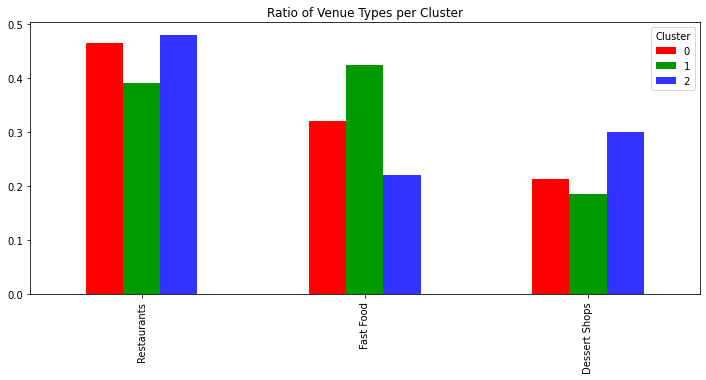

In [21]:
%matplotlib inline
cluster_df[
    ["RatioRestaurants", "RatioFastFood", "RatioFoodShops"]
].rename({
    "RatioRestaurants": "Restaurants",
    "RatioFastFood": "Fast Food",
    "RatioFoodShops": "Dessert Shops",
}, axis=1).T.plot(
    kind="bar",
    title="Ratio of Venue Types per Cluster",
    figsize=(12, 5),
    colormap=MPL_COLORMAP,
)

Venues in cluster \#2 seems to be really popular! That seems to be the factor that makes that single location stand out into its own cluster.

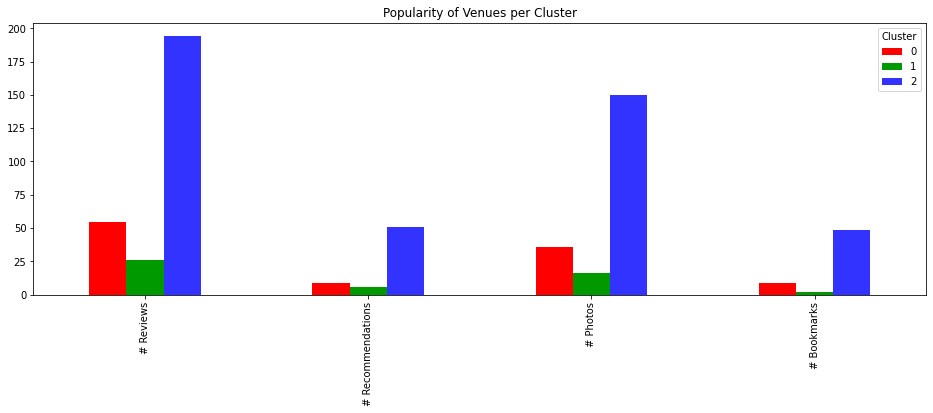

In [22]:
%matplotlib inline
cluster_df[
    ["RatingReviews", "TipsCount", "PhotosCount", "ListsCount"]
].rename({
    "RatingReviews": "# Reviews",
    "TipsCount": "# Recommendations",
    "PhotosCount": "# Photos",
    "ListsCount": "# Bookmarks"
}, axis=1).T.plot(
    kind="bar",
    title="Popularity of Venues per Cluster",
    figsize=(16, 5),
    colormap=MPL_COLORMAP,
)

Finally, average rating for cluster \#1 is somewhat lower than the other clusters.

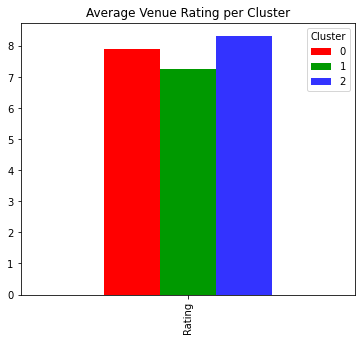

In [23]:
%matplotlib inline
cluster_df[["Rating"]].T.plot(
    kind="bar",
    title="Average Venue Rating per Cluster",
    figsize=(6, 5),
    colormap=MPL_COLORMAP,
)

Looking at these numbers, it seems locations in cluster \#1 are probably the best to pick to establish a new Italian restaurant, since the competition seems lower and the existing venues are lower rated.

At this point in the meeting, we can dig deeper into the specific locations in cluster \#1 to gauge interest from the customer and narrow down a couple of locations for a deeper look into specifics of those locations.

In [24]:
summary_df[summary_df["Cluster"] == 1].sort_values("MatchingVenues", ascending=False)

,Cluster,LocationId,LocationLatitude,LocationLongitude,TotalVenues,RatioRestaurants,RatioFastFood,RatioFoodShops,MatchingVenues,Rating,RatingReviews,PriceTier,TipsCount,PhotosCount,ListsCount
0,1,Downtown Kirkland,47.675917,-122.206802,49.0,0.428571,0.387755,0.183673,6.0,7.350000,38.250000,1.666667,8.666667,24.500000,4.333333
2,1,Totem Lake Kirkland,47.711746,-122.180346,48.0,0.479167,0.354167,0.166667,6.0,7.160000,58.400000,1.333333,12.333333,37.333333,4.166667
8,1,Downtown Renton,47.479960,-122.213410,49.0,0.428571,0.428571,0.142857,6.0,6.960000,21.800000,1.500000,5.000000,16.333333,2.166667
9,1,Downtown Lake City,47.719895,-122.296499,49.0,0.510204,0.408163,0.081633,6.0,6.800000,13.000000,1.166667,1.833333,2.500000,0.166667
5,1,Sammamish Downtown,47.615423,-122.033238,23.0,0.217391,0.521739,0.260870,5.0,7.050000,18.250000,1.000000,5.200000,17.600000,1.600000
6,1,Woodinville,47.757351,-122.154019,48.0,0.354167,0.416667,0.229167,5.0,7.775000,23.500000,1.400000,3.600000,15.400000,2.200000
12,1,Downtown Bothell,47.760822,-122.206673,45.0,0.288889,0.400000,0.311111,5.0,7.833333,21.666667,1.600000,3.200000,9.600000,2.800000
7,1,Factoria Mall,47.576039,-122.172406,48.0,0.416667,0.479167,0.104167,3.0,7.100000,15.000000,1.000000,3.666667,6.333333,1.000000


### Discussion

The data analysis allowed us to cluster locations with similar features, which let us make a decision based on high level features first, and then narrow down to specific locations within that cluster.

This allowed us to quickly half the number of possibilities to consider.

We also presented data that let us drill down into specifics of each location inside the selected cluster, to work with the customer to make a final decision or commission a more detailed study of two or three locations that look particularly interesting based on the findings.


### Conclusion

Foursquare data can be very useful for making decisions on location data, the breadth of information available on the venues (in this particular case, restaurants) is pretty interesting for this kind of application involving recommendations.

K-Means Clustering is a useful technique to segment data into similar clusters, which can be very helpful in narrowing down a decision on a large group of options. By grouping them into a handful of clusters, we can initially pick the cluster that looks most interesting, then dig down into the smaller number of specific elements inside that cluster.

The Python tools for Data Science (Pandas, IPython, Jupyter, etc.) make it very easy to explore data dynamically, while at the same time keeping a "paper trail" and at the same time allowing for a pretty report to be produced, which makes it easy to go from ad-hoc exploration, to a draft, to a final report that looks very professional.

This course was a very great use of my time.